# Double integrator

The goal is to control the movement of a object on the $x$-axis in order to bring it to a stop at $x = 0$. The state of the object at time $t$ is given by its position $x$ and its velocity $\dot{x}$, i.e. the vector $\begin{bmatrix} x_t \\ \dot{x}_t \end{bmatrix}$. The control input is the acceleration $a$ applied to the object. 

The dynamics of the object are given by the following differential equation:
$$ x_{t+1} = x_t + \dot{x}_t \text{d}t $$
$$ \dot{x}_{t+1} = \dot{x}_t + a_t \text{d}t$$

This example serves to illustrate how to discretize a model with continuous state and action spaces in a way that is compatible with the *madupite* library in order to solve for its optimal control policy.

The model is taken from and explained in more detail in [Underactuated Robotics, Ch. 7, Russ Tedrake](https://underactuated.csail.mit.edu).

In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import madupite as md

## Model formulation

We start by declaring a few constants and model parameters.

In [2]:
NUM_X = 41
NUM_XD = 41
NUM_A = 11
MAX_X = 3.0
MAX_XD = 4.0
MAX_A = 1.0
DT = 0.1

# derived constants - do not modify
NUM_STATES = NUM_X * NUM_XD
NUM_ACTIONS = NUM_A

x_vals = np.linspace(-MAX_X, MAX_X, NUM_X)
xd_vals = np.linspace(-MAX_XD, MAX_XD, NUM_XD)
a_vals = np.linspace(-MAX_A, MAX_A, NUM_A)

Some helper functions that we need later. We use subscript `i` to denote indices (int) and `v` to denote values (float) as well as `t` ($t$) and `tpp` ($t+1$) for better readability.

In [3]:
def x2s(x, xd):
    """Convert [x, xd] to 1-dim state (row-major)."""
    return int(x * NUM_XD + xd)

def s2x(s):
    """Convert 1-dim state to [x, xd]."""
    return s // NUM_XD, s % NUM_XD

def interpolate(x, y, grid_x, grid_y):
    """
    Bilinear interpolation of a 2D grid at point (x, y).
    Returns the indices of the 4 grid points surrounding (x, y) and their weights.
    """
    x_i = np.searchsorted(grid_x, x, side='right')
    y_i = np.searchsorted(grid_y, y, side='right')

    x_i = np.clip(x_i, 1, len(grid_x) - 1)
    y_i = np.clip(y_i, 1, len(grid_y) - 1)

    xl_v, xr_v = grid_x[x_i-1], grid_x[x_i]
    yl_v, yr_v = grid_y[y_i-1], grid_y[y_i]

    wx1 = (x - xl_v) / (xr_v - xl_v)
    wx0 = 1 - wx1
    wy1 = (y - yl_v) / (yr_v - yl_v)
    wy0 = 1 - wy1

    indices = [(x_i-1, y_i-1), (x_i, y_i-1), (x_i-1, y_i), (x_i, y_i)]
    weights = [wx0*wy0, wx1*wy0, wx0*wy1, wx1*wy1]

    return indices, weights

Next, we define the model dynamics, i.e. calculate the next state given the current state and action.

In [4]:
def step(s, a):
    """
    Calculate the next state for a given state-action pair.
    
    Parameters:
    s: int, current state index(!) (value in [0, NUM_STATES))
    a: int, action index (value in [0, NUM_ACTIONS))

    Returns:
    x_next, xd_next: float(!), coordinate values of the next state in [-MAX_X, MAX_X] and [-MAX_XD, MAX_XD]
    """
    x_t_i, xd_t_i = s2x(s)
    x_t_v = x_vals[x_t_i]
    xd_t_v = xd_vals[xd_t_i]
    a_t_v = a_vals[a]

    x_tpp_v = np.clip(x_t_v + xd_t_v * DT, -MAX_X, MAX_X)
    xd_tpp_v = np.clip(xd_t_v + a_t_v * DT, -MAX_XD, MAX_XD)

    return x_tpp_v, xd_tpp_v   

Now we can construct the transition probability function. The function returns the list of possible next states and the corresponding probabilities for a given current state and action.

In [5]:
def transition_probabilities(s_t_i, a_t_i):
    x_tpp_v, xd_tpp_v = step(s_t_i, a_t_i)
    indices, weights = interpolate(x_tpp_v, xd_tpp_v, x_vals, xd_vals)

    # indices -> x2s


    return weights, [x2s(x, xd) for x, xd in indices]

Next, we define the stage cost function. In this case, the goal is to get the object to stop at $x = 0$, i.e. $x = 0$ and $\dot{x} = 0$. We can define the stage cost as the squared distance to the goal, which makes the function independent of the action.

The stage cost function is given by:

In [6]:
def stage_cost(s_t_i, a_t_i):
    x_i, xd_i = s2x(s_t_i)
    return x_vals[x_i]**2 + xd_vals[xd_i]**2

Now we save the matrices to file in order to load them in madupite:

# Solving the model using madupite

We start by initializing madupite to set up the communication between the MPI processes properly.

In [7]:
md.initialize_madupite()

We can then create the transition probability tensor whose elements are given by the transition probability function above. In order to this efficiently, we first preallocate the tensor: Because of the bilinear interpolation in the 2D space, we have at most 4 entries per row (state-action pair). Hence, we preallocate 4 elements in the diagonal and 4 elements in the off-diagonal. We then fill the tensor with the transition probabilities.

In [8]:
prealloc = md.MatrixPreallocation()
prealloc.d_nz = 4
prealloc.o_nz = 4

P = md.createTransitionProbabilityTensor(
    numStates=NUM_STATES,
    numActions=NUM_ACTIONS,
    func=transition_probabilities,
    preallocation=prealloc
)

We repeat the same for the stage costs. Since this matrix is stored as a dense matrix, no preallocation is necessary.

In [9]:
g = md.createStageCostMatrix(
    numStates=NUM_STATES,
    numActions=NUM_ACTIONS,
    func=stage_cost
)

Now we can create the MDP object, configure the optimization parameters and finally solve the MDP.

In [10]:
mdp = md.MDP()
mdp.setOption("-mode", "MINCOST")
mdp.setOption("-discount_factor", "0.99")
mdp.setOption("-file_cost", "di_cost.out")
mdp.setOption("-file_policy", "di_policy.out")
mdp.setOption("-file_stats", "di_stats.json")
mdp.setOption("-verbose", "") # enable console output
mdp.setOption("-overwrite", "") # overwrite existing files (so we don't need to adapt the filenames in the plotting script below)

mdp.setTransitionProbabilityTensor(P)
mdp.setStageCostMatrix(g)

mdp.solve()

discount_factor = 0.990000
mode = MINCOST
max_iter_pi not specified. Using default value: 1000.
max_iter_ksp not specified. Using default value: 1000.
alpha not specified. Using default value: 1e-4.
atol_pi not specified. Using default value: 1e-8.
Solving MDP using iPI with 1681 states, 11 actions and discount factor 0.990000
iPI iteration 0: residual norm = 2.499000e+01, time elapsed = 11.905234 ms
iPI iteration 1: residual norm = 1.281608e+02, time elapsed = 45.759604 ms
iPI iteration 2: residual norm = 5.816746e+01, time elapsed = 52.868466 ms
iPI iteration 3: residual norm = 3.887196e+01, time elapsed = 61.683281 ms
iPI iteration 4: residual norm = 2.980577e+01, time elapsed = 73.722905 ms
iPI iteration 5: residual norm = 1.250600e+02, time elapsed = 84.867292 ms
iPI iteration 6: residual norm = 1.034779e+02, time elapsed = 91.213663 ms
iPI iteration 7: residual norm = 5.110295e+01, time elapsed = 96.483685 ms
iPI iteration 8: residual norm = 3.806278e+01, time elapsed = 102.58214

## Plotting the solution

After having solved for the model's optimal control policy and value function, we want to visualize. To do so, we transform the 1D state index back to the 2D state space for $x$ and $\dot{x}$.

In [11]:
def reshape_data(data, shape):
    return np.rot90(data.reshape(shape), k=1)

def create_tick_labels(values, num_ticks):
    indices = np.linspace(0, len(values) - 1, num_ticks, dtype=int)
    return indices, [f"{val:.2f}" for val in values[indices]]

def plot_heatmap(ax, data, title, x_val, xd_val):
    im = ax.imshow(data, cmap='jet', interpolation='nearest')
    ax.set_title(title)
    ax.set_ylabel(r"$\dot{x}$")
    ax.set_xlabel(r"$x$")
    
    yticks, yticklabels = create_tick_labels(xd_val[::-1], 5)
    xticks, xticklabels = create_tick_labels(x_val, 5)
    
    ax.set_yticks(yticks)
    ax.set_xticks(xticks)
    ax.set_yticklabels(yticklabels)
    ax.set_xticklabels(xticklabels)
    
    return im

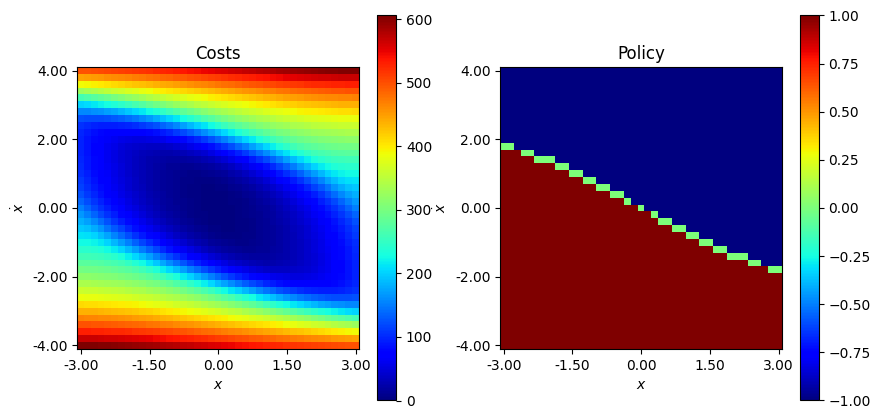

In [12]:
costs = reshape_data(np.loadtxt("di_cost.out"), (NUM_X, NUM_XD))
policy = np.loadtxt("di_policy.out", dtype=int)
user_input = reshape_data(a_vals[policy], (NUM_X, NUM_XD))

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

im1 = plot_heatmap(ax1, costs, "Costs", x_vals, xd_vals)
im2 = plot_heatmap(ax2, user_input, "Policy", x_vals, xd_vals)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

plt.show()